Advanced Topics on Sinkhorn Algorithm
=====================================
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$
$\newcommand{\eqdef}{\equiv}$

This numerical tour explore several extensions of the basic Sinkhorn
method.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Log-domain Sinkhorn 
--------------------
For simplicity, we consider uniform distributions on point clouds, so
that the associated histograms are $ (a,b) \in \RR^n \times \RR^m$
being constant $1/n$ and $1/m$.

In [57]:
n = 100
m = 200
a = np.ones((n,1))/n
b = np.ones((1,m))/m

Point clouds $x$ and $y$.

In [3]:
x1 = .4*np.random.randn(2,n//2)
x2 = .4*np.random.randn(2,n//2)
x2 /= np.linalg.norm(x2, axis=0)
x2[:] = 1.9 * x2 + .1*np.random.randn(2, n//2)
x = np.hstack((x1, x2))

theta = 2*np.pi*np.random.rand(1,m)
r = 1.1 + .4*np.random.rand(1,m)
y = np.vstack((np.cos(theta)*r,np.sin(theta)*r))

Display of the two clouds.

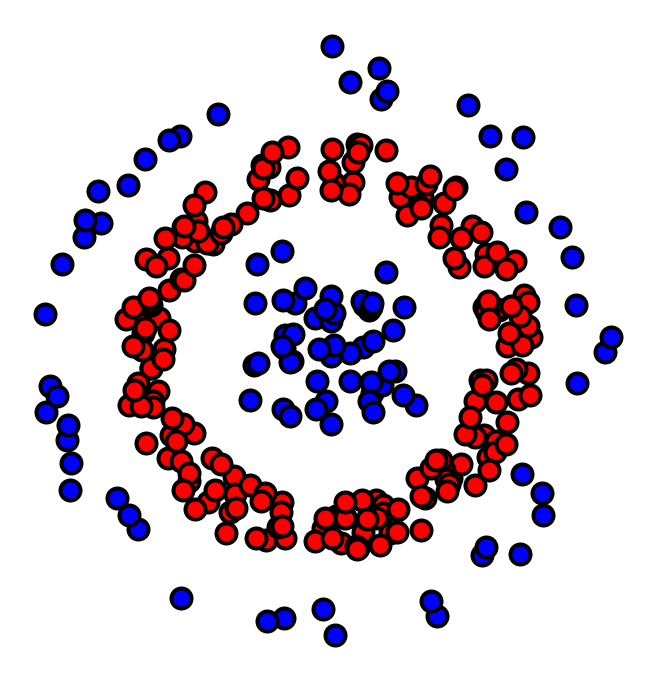

In [4]:
plotp = lambda x,col: plt.scatter(x[0,:], x[1,:], s=100, edgecolors="k", c=col, linewidths=2)
plt.figure(figsize=(6,6))
plotp(x, 'b')
plotp(y, 'r')
plt.axis("off");
plt.axis('scaled');

Cost matrix $C_{i,j} = \norm{x_i-y_j}^2$.

In [5]:
def distmat(x,y):
    return np.sum(x**2,0)[:,None] + np.sum(y**2,0)[None,:] - 2*x.transpose().dot(y)
C = distmat(x,y)

Sinkhorn algorithm is originally implemented using matrix-vector
multipliciation, which is unstable for small epsilon.
Here we consider a log-domain implementation, which operates by
iteratively updating so-called Kantorovitch dual potentials $ (f,g) \in \RR^n \times \RR^m $.


The update are obtained by regularized c-transform, which reads
$$ f_i \leftarrow {\min}_\epsilon^b( C_{i,\cdot} - g ) $$
$$ g_j \leftarrow {\min}_\epsilon^a( C_{\cdot,j} - f ),  $$
where the regularized minimum operator reads
$$ {\min}_\epsilon^a(h) \eqdef -\epsilon \log \sum_i a_i e^{-h_i/\epsilon}. $$

In [6]:
def mina_u(H,epsilon): return -epsilon*np.log( np.sum(a * np.exp(-H/epsilon),0) )
def minb_u(H,epsilon): return -epsilon*np.log( np.sum(b * np.exp(-H/epsilon),1) )

The regularized min operator defined this way is non-stable, but it can
be stabilized using the celebrated log-sum-exp trick, wich relies on the
fact that for any constant $c \in \RR$, one has
$$ {\min}_\epsilon^a(h+c) = {\min}_\epsilon^a(h) + c,  $$
and stabilization is achieved using $c=\min(h)$.

In [7]:
def mina(H,epsilon): 
    hmin = np.min(H,0)
    return mina_u(H-hmin,epsilon) + hmin

def minb(H,epsilon):
    hmin = np.min(H,1)
    return minb_u(H-hmin[:,None],epsilon) + hmin

Value of $\epsilon$. 

In [8]:
epsilon = .01

__Exercise 1__

Implement Sinkhorn in log domain.

In [9]:
from scipy.special import logsumexp

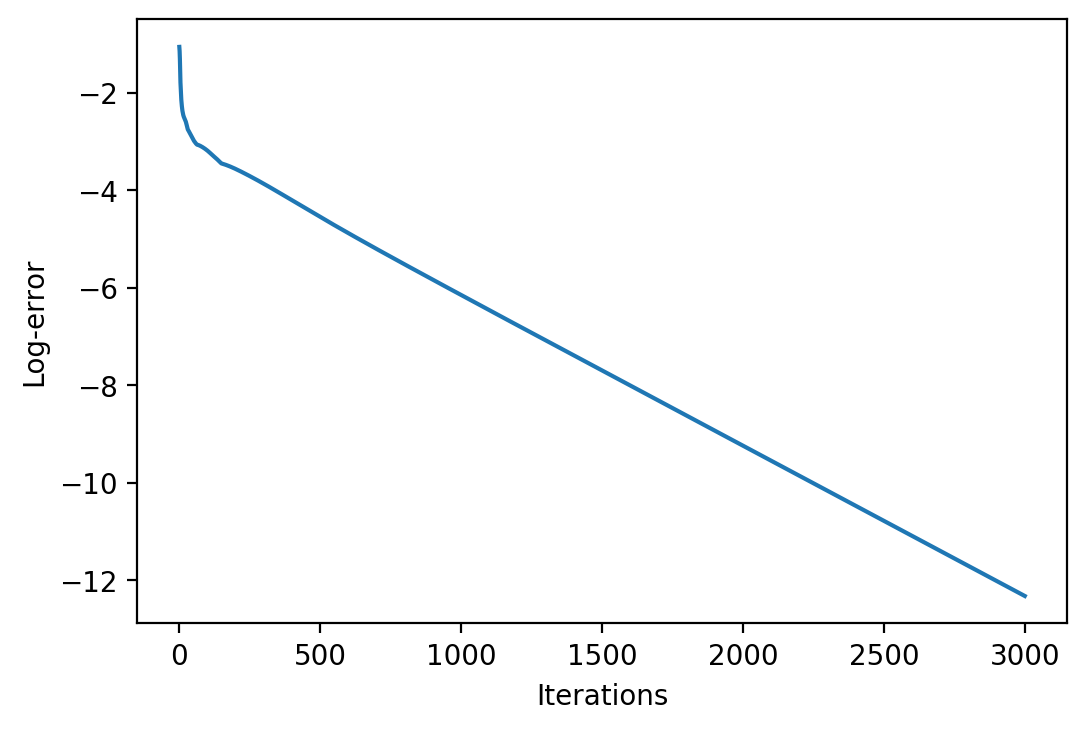

In [10]:
def Sinkhorn(C, epsilon, f, niter=500, compute_errs=True):
    """
    Sinkhorn (log-domain) algorithm.
    """
    Err = np.zeros(niter)
    K = np.exp(-C/epsilon)
    for it in range(niter):
        g = mina(C-f[:,None], epsilon)
        f = minb(C-g[None,:], epsilon)
        # generate the coupling
        # check conservation of mass
        if compute_errs:  # slows things down so optional
            P = a * np.exp((f[:,None]+g[None,:]-C)/epsilon) * b
            r = P.sum(0)
            Err[it] = np.linalg.norm(r-b,1)
    if not compute_errs:
        # compute P because not already computed
        P = a * np.exp((f[:,None]+g[None,:]-C)/epsilon) * b
    return (P,Err)

# run with 0 initialization for the potential f
fig = plt.figure(dpi=100)
(P,Err) = Sinkhorn(C,epsilon,np.zeros(n),3000, compute_errs=True)  
plt.plot(np.log10(Err));
plt.xlabel("Iterations")
plt.ylabel("Log-error");

__Exercise 2__

Study the impact of $\epsilon$ on the convergence rate of the algorithm.

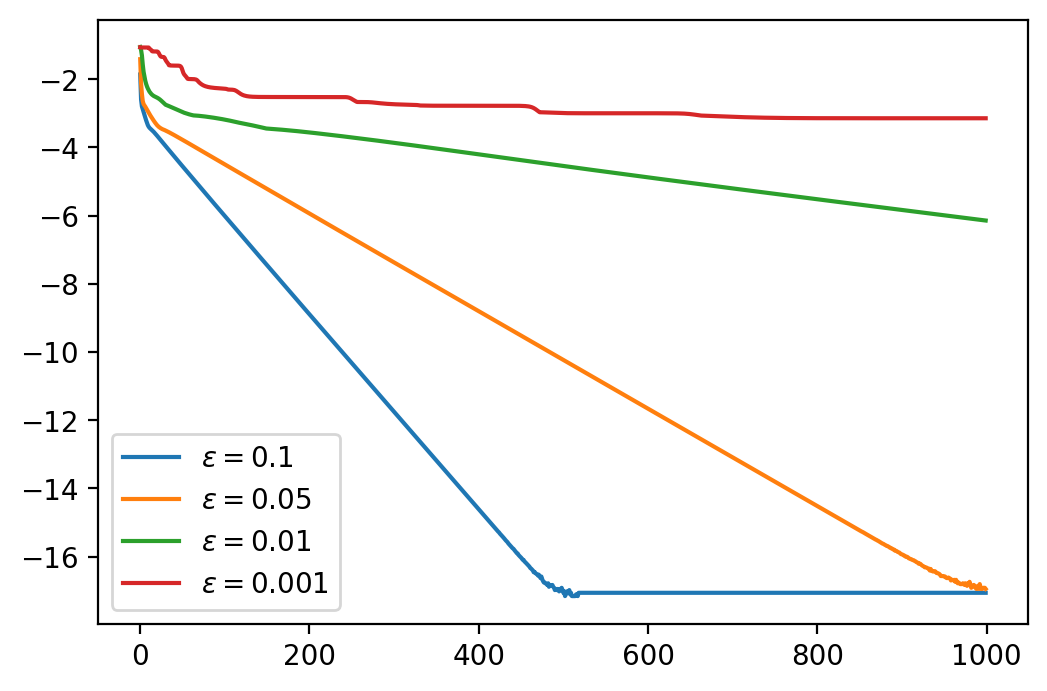

In [11]:
fig = plt.figure(dpi=100)
for epsilon in (.1, .05, .01, .001):
    (P,Err) =  Sinkhorn(C,epsilon,np.zeros(n),1000)  
    plt.plot(np.log10(Err), label='$\epsilon=$' + str(epsilon))
plt.legend();

In [12]:
fig.savefig("advanced_logsinkhorn_convergence.png", dpi='figure')

Wasserstein Flow for Matching 
------------------------------
We aim at performing a "Lagrangian" gradient (also called Wasserstein flow) descent of Wasserstein
distance, in order to perform a non-parametric fitting. This corresponds
to minimizing the energy function
$$ \Ee(z) \eqdef W_\epsilon\pa{ \frac{1}{n}\sum_i \de_{z_i}, \frac{1}{m}\sum_i \de_{y_i} }. $$


Here we have denoted the Sinkhorn score as
$$ W_\epsilon(\al,\be) \eqdef \dotp{P^*}{C} - \epsilon \text{KL}(P^*|ab^\top)$$
where $\al=\frac{1}{n}\sum_i \de_{x_i}$ and
$\be=\frac{1}{m}\sum_i \de_{y_i}$ are the measures (beware that $C$
depends on the points positions).

In [13]:
z = x # initialization

The gradient of this energy reads
$$ ( \nabla \Ee(z) )_i = \sum_j P_{i,j}(z_i-y_j) = a_i z_i - \sum_j P_{i,j} y_j,  $$
where $P$ is the optimal coupling. It is better to consider a renormalized gradient, which corresponds
to using the inner product associated to the measure $a$ on the
deformation field, in which case
$$ ( \bar\nabla \Ee(z) )_i = z_i - \bar y_i   \qwhereq \bar y_i \eqdef \frac{\sum_j P_{i,j} y_j}{a_i}.  $$
Here $\bar y_i$ is often called the "barycentric projection" associated
to the coupling matrix $P$.


First run Sinkhorn, beware you need to recompute the cost matrix at each step.

In [14]:
epsilon = .01
niter = 300
(P,Err) = Sinkhorn(distmat(z,y), epsilon, np.zeros(n),niter, compute_errs=False);

Compute the gradient

In [15]:
G = z - ( y.dot(P.transpose()) ) / a.transpose()

Display the gradient field.

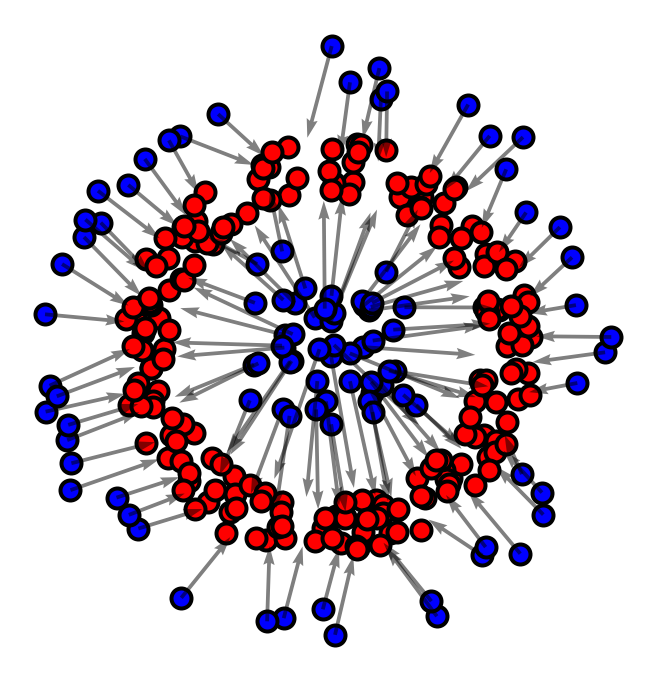

In [16]:
fig = plt.figure(figsize=(6,6))
plotp(x, 'b')
plotp(y, 'r')
#for i in range(n):
    #plt.plot([x[0,i], x[0,i]-G[0,i]], [x[1,i], x[1,i]-G[1,i]], 'k')
plt.quiver(x[0, :], x[1,:], -G[0, :], -G[1,:], scale=5, alpha=.5, ls='--')
plt.axis("off");
plt.axis('scaled');

Set the descent step size.

In [17]:
tau = .1

Update the point cloud.

In [18]:
z = z - tau * G

__Exercise 3__

Implement the gradient flow.

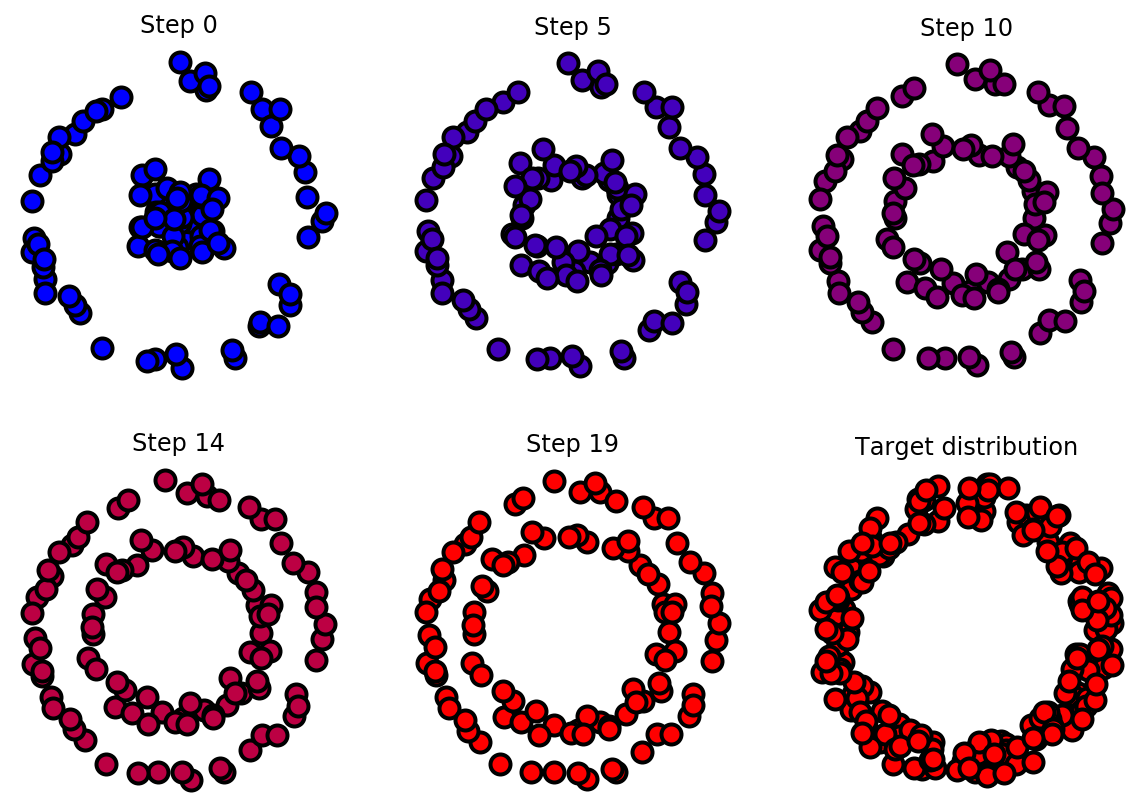

In [19]:
z = x; # (re)initialization
tau = .08; # step size for the descent
giter = 20; # iter for the gradient descent
nplots = 6
ndisp = np.round( np.linspace(0,giter-1, nplots-1) )
kdisp = 0
fig = plt.figure(figsize=(10, 7))
f = np.zeros(n) # use warm restart in the following

for j in range(giter):
    # drawing
    if ndisp[kdisp]==j:        
        plt.subplot(2,3,kdisp+1)
        s = j/(giter-1)
        col = np.array([s,0,1-s])[None,:]
        plotp(z, col )
        plt.title("Step %d" % j)
        plt.axis("off")
        plt.axis('scaled')
        kdisp = kdisp+1
    # Sinkhorn
    C = distmat(z,y)
    (P,Err) = Sinkhorn(C, epsilon, f, niter, compute_errs=False)
    # gradient
    G = z - ( y.dot(P.transpose()) ) / a.transpose()
    z = z - tau * G;
plt.subplot(2,3,nplots)
plotp(y, col )
plt.title("Target distribution")
plt.axis("off")
plt.axis('scaled');


In [20]:
fig.savefig("advanced_wasserstein_flow_matching.pdf", bbox_inches='tight')

__Exercise 4__

Show the evolution of the fit as $\epsilon$ increases. What do you observe.
Replace the Sinkhorn score $W_\epsilon(\al,\be)$ by the Sinkhorn divergence
$W_\epsilon(\al,\be)-W_\epsilon(\al,\al)/2-W_\epsilon(\be,\be)/2$.

In [21]:
from scipy.special import kl_div

def objective_wass(C, P, a, b, epsilon):
    r"""Compute the objective :math:`W_\epsilon(\alpha,\beta)`.
    """
    lin = np.sum(C * P)
    return lin + epsilon * np.sum(kl_div(P, np.outer(a, b)))

In [22]:
## Insert your code here.
def wasserstein_fit(x, y, tau=.07, epsilon=.01):
    z = x; # initialization
    giter = 20; # iter for the gradient descent
    f = np.zeros(x.shape[1]) # use warm restart in the following

    for j in range(giter):
        # drawing
        # Sinkhorn
        C = distmat(z,y)
        (P,Err) = Sinkhorn(C, epsilon,f,niter, compute_errs=False)
        # gradient
        G = z - ( y.dot(P.transpose()) ) / a.transpose()
        z = z - tau * G;
    
    ## Wasserstein distance between last iterate z and target y
    final_dist = objective_wass(C, P, a, b, epsilon)
    
    fig = plt.figure()
    plt.subplot(1,3,1)
    col = np.array([[0., 0., 1.]])
    plotp(x, col)
    plt.title("Initial")
    plt.axis("off")
    plt.axis('scaled');
    
    plt.subplot(1,3,2)
    col = np.array([[.8, 0., .2]])
    plotp(z, col)
    plt.title("Final fit")
    plt.axis("off")
    plt.axis('scaled');
    
    plt.subplot(1,3,3)
    col = np.array([[1., 0., 0.]])
    plotp(y, col)
    plt.title("Target distribution")
    plt.axis("off")
    plt.axis('scaled');
    
    return final_dist

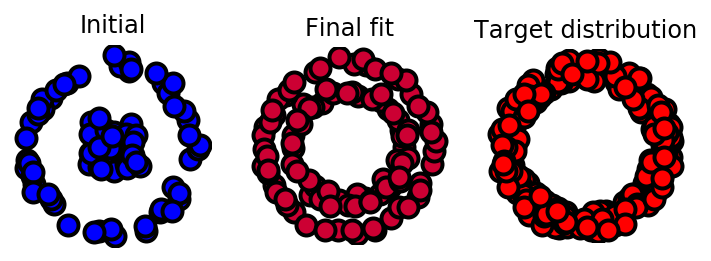

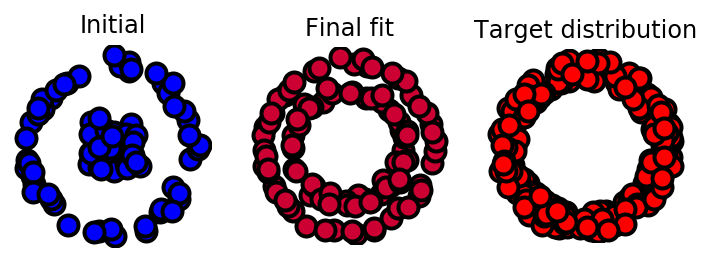

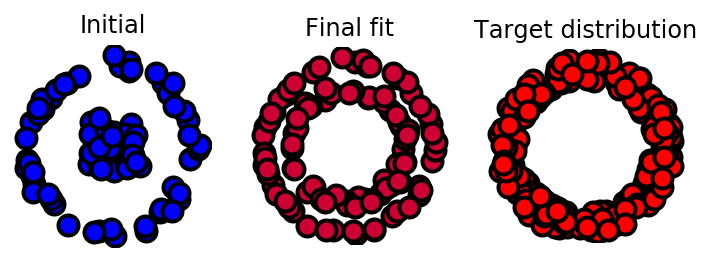

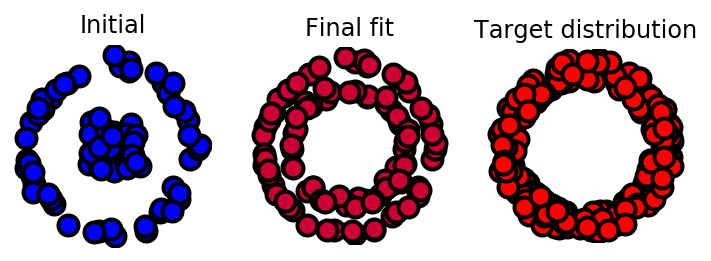

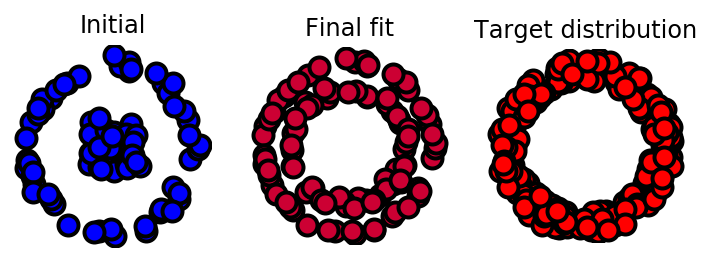

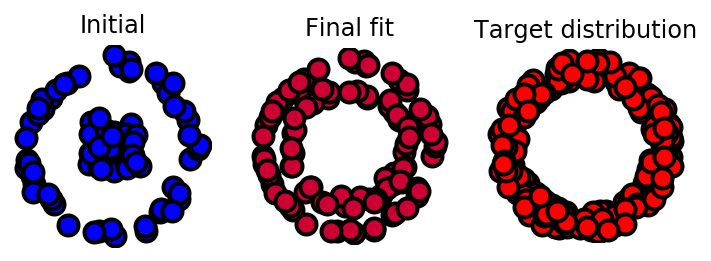

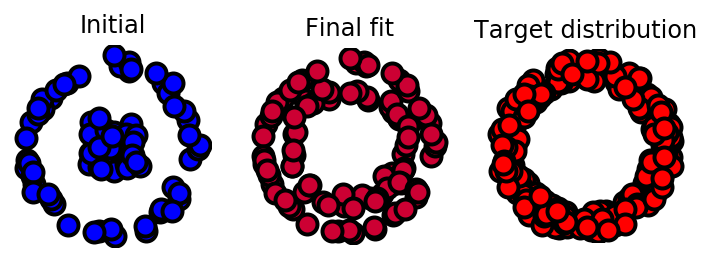

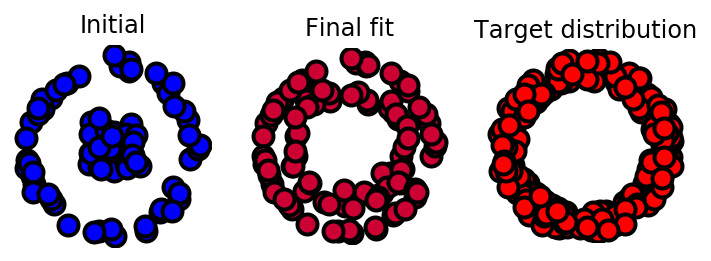

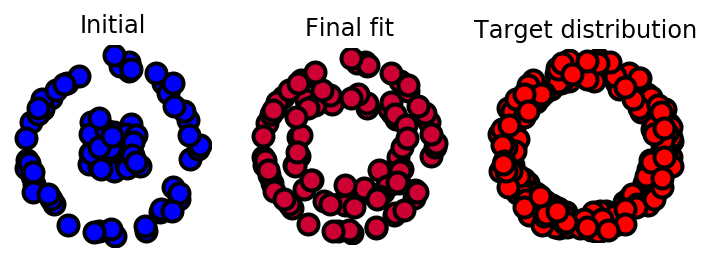

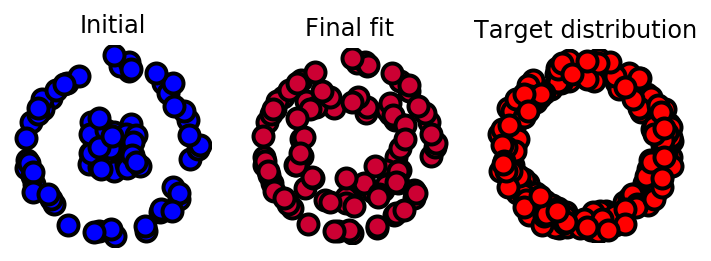

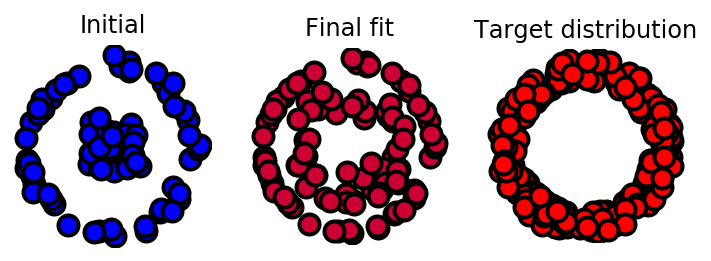

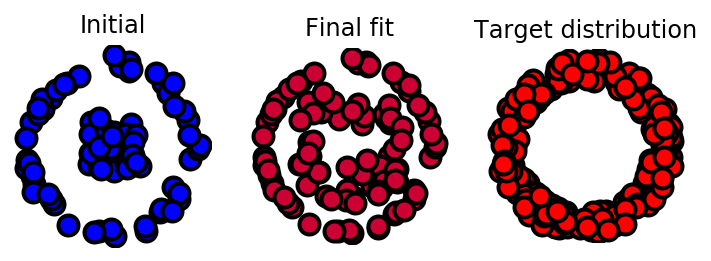

In [23]:
epsilon_vals = [0.01, 0.02, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4,
                0.5, 0.6, 0.7, 0.8]
weps_vals = []
for eps in epsilon_vals:
    weps_dist = wasserstein_fit(x, y, epsilon=eps)
    weps_vals.append(weps_dist)

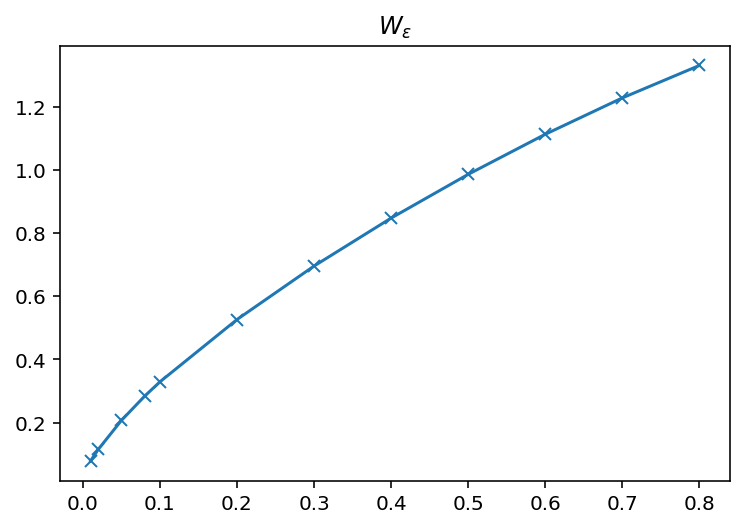

In [25]:
fig = plt.figure()
plt.plot(epsilon_vals, weps_vals, marker='x');
plt.title("$W_\\epsilon$");

In [111]:
def sinkhorn_divg_score(C, Cz, Cy, P, Pz, Py, a, b, epsilon):
    lin1 = np.sum(C * P)
    lin2 = np.sum(Cz * Pz)
    lin3 = np.sum(Cy * Py)
    term1 = lin1 + epsilon * np.sum(kl_div(P, np.outer(a, b)))
    term2 = lin2 + epsilon * np.sum(kl_div(Pz, np.outer(a, a)))
    term3 = lin3 + epsilon * np.sum(kl_div(Py, np.outer(b, b)))
    return term1 - 0.5 * term2 - 0.5 * term3

def Sinkhorn_a(C, epsilon, f, niter=500, compute_errs=True):
    """
    Sinkhorn (log-domain) algorithm.
    """
    Err = np.zeros(niter)
    K = np.exp(-C/epsilon)
    for it in range(niter):
        g = mina(C-f[:,None], epsilon)
        f = mina(C.T-g[:,None], epsilon)
        # generate the coupling
        # check conservation of mass
        if compute_errs:  # slows things down so optional
            P = a * np.exp((f[:,None]+g[None,:]-C)/epsilon) * a.T
            r = P.sum(0)
            Err[it] = np.linalg.norm(r-a.T,1)
    if not compute_errs:
        # compute P because not already computed
        P = a * np.exp((f[:,None]+g[None,:]-C)/epsilon) * a.T
    return (P,Err)

def Sinkhorn_b(C, epsilon, f, niter=500, compute_errs=True):
    """
    Sinkhorn (log-domain) algorithm.
    """
    Err = np.zeros(niter)
    K = np.exp(-C/epsilon)
    for it in range(niter):
        g = minb(C-f[None,:], epsilon)
        f = minb(C-g[None,:], epsilon)
        # generate the coupling
        # check conservation of mass
        if compute_errs:  # slows things down so optional
            P = b.T * np.exp((f[:,None]+g[None,:]-C)/epsilon) * b
            r = P.sum(0)
            Err[it] = np.linalg.norm(r-b,1)
    if not compute_errs:
        # compute P because not already computed
        P = b.T * np.exp((f[:,None]+g[None,:]-C)/epsilon) * b
    return (P,Err)

## Insert your code here.
def wasserstein_fit_divg(x, y, tau=.07, epsilon=.01):
    z = x; # initialization
    giter = 20; # iter for the gradient descent
    f = np.zeros(x.shape[1]) # use warm restart in the following
    g = np.zeros(y.shape[1]) # use warm restart in the following
    
    for j in range(giter):
        # drawing
        # Sinkhorn
        C = distmat(z,y)
        (P,Err) = Sinkhorn(C, epsilon,f,niter, compute_errs=False)
        Cz = distmat(z,z)
        (Pz,_) = Sinkhorn_a(Cz, epsilon,f,niter, compute_errs=False)
        Cy = distmat(y,y)
        (Py,_) = Sinkhorn_b(Cy, epsilon,g,niter, compute_errs=False)
        # gradient
        #print(Pz.shape, z.shape)
        #print(P.shape, y.shape)
        P @ y.T
        G = (( .5 * (Pz @ z.T + Pz.T @ z.T) - P @ y.T ) / a).T
        z = z - tau * G;
        
    ## Wasserstein distance between last iterate z and target y
    final_dist = sinkhorn_divg_score(C, Cz, Cy, P, Pz, Py, a, b, epsilon)
    
    fig = plt.figure()
    plt.subplot(1,3,1)
    col = np.array([[0., 0., 1.]])
    plotp(x, col)
    plt.title("Initial")
    plt.axis("off")
    plt.axis('scaled');
    
    plt.subplot(1,3,2)
    col = np.array([[.8, 0., .2]])
    plotp(z, col)
    plt.title("Final fit")
    plt.axis("off")
    plt.axis('scaled');
    
    plt.subplot(1,3,3)
    col = np.array([[1., 0., 0.]])
    plotp(y, col)
    plt.title("Target distribution")
    plt.axis("off")
    plt.axis('scaled');
    
    return final_dist

0.0001
0.001
0.01
0.1
0.8


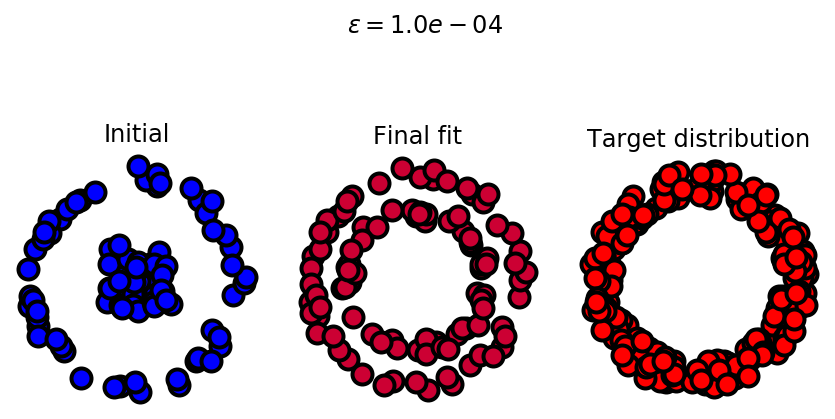

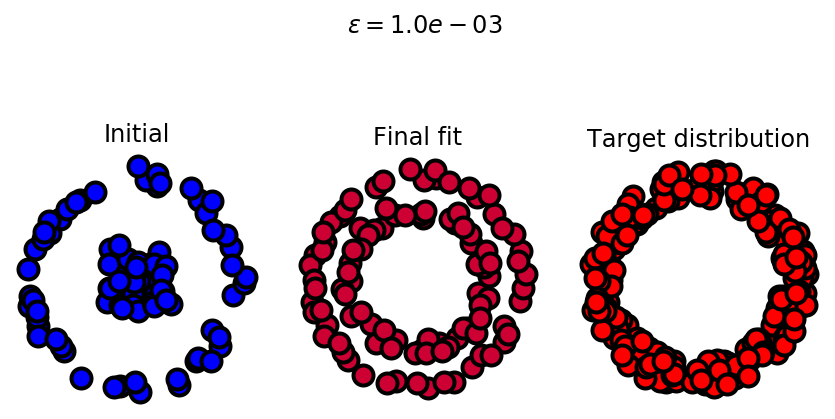

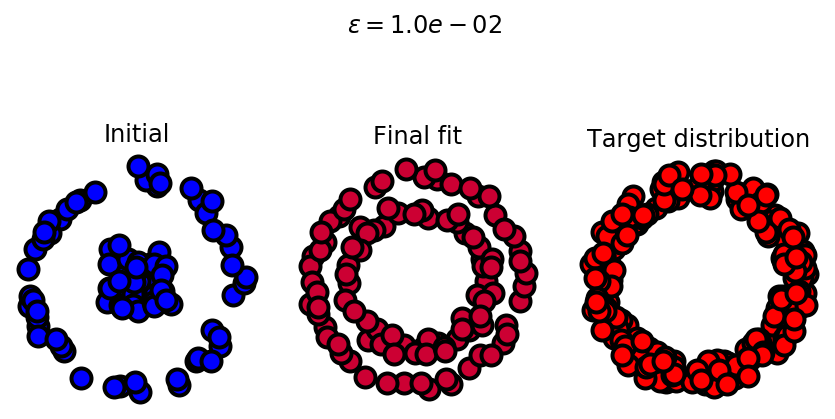

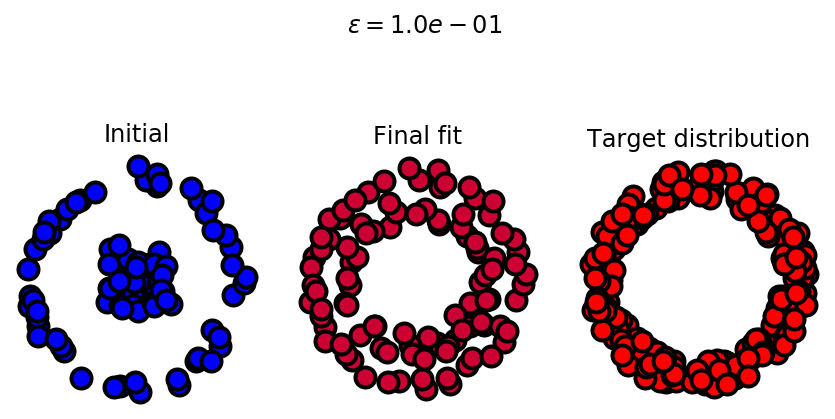

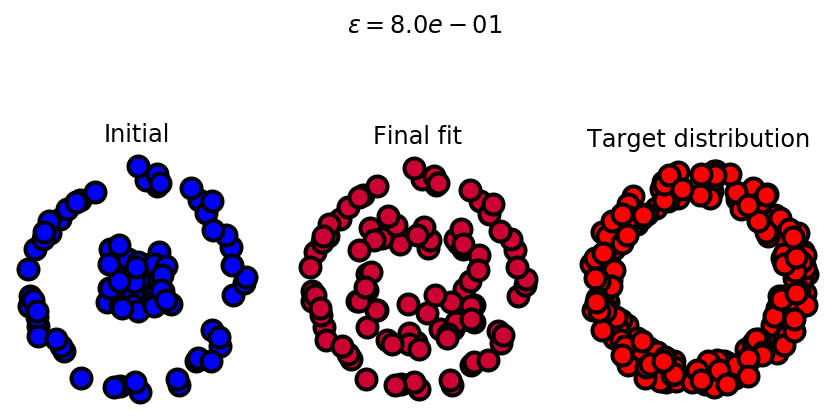

In [118]:
epsilon_vals = [1e-4, 0.001, 0.01, 0.1, 0.8]
wdiveps_vals = []
for eps in epsilon_vals:
    weps_dist = wasserstein_fit_divg(x, y, epsilon=eps)
    print(eps)
    plt.suptitle("$\\epsilon=%.1e$" % eps, y=0.96)
    plt.tight_layout()
    wdiveps_vals.append(weps_dist)

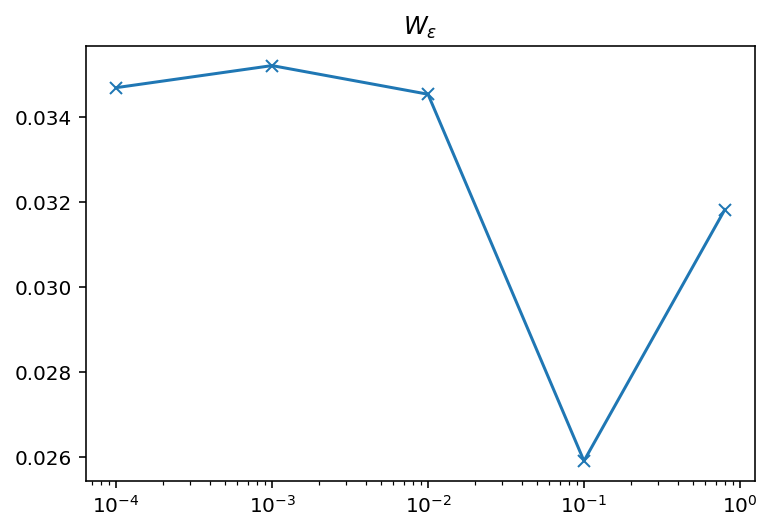

In [121]:
fig = plt.figure()
plt.plot(epsilon_vals, wdiveps_vals, marker='x');
plt.xscale("log")
plt.title("$W_\\epsilon$");

Generative Model Fitting
------------------------
The Wasserstein is a non-parametric idealization which does not
corresponds to any practical application. We consider here a simple toy
example of density fitting, where the goal is to find a parameter $\theta$
to fit a deformed point cloud of the form $ (g_\theta(x_i))_i $ using a
Sinkhorn cost. This is ofen called a generative model in the machine
learning litterature, and corresponds to the problem of shape
registration in imaging.


The matching is achieved by solving
$$ \min_\th \Ff(\th) \eqdef \Ee(G_\th(z)) =  W_\epsilon\pa{ \frac{1}{n}\sum_i \de_{g_\th(z_i)}, \frac{1}{m}\sum_i \de_{y_i} },  $$
where the function $G_\th(z)=( g_\th(z_i) )_i$ operates independently on
each point.


The gradient reads
$$ \nabla \Ff(\th) = \sum_i \partial g_\th(z_i)^*[ \nabla \Ee(G_\th(z))_i ], $$
where $\partial g_\th(z_i)^*$ is the adjoint of the Jacobian of
$g_\th$.


We consider here a simple model of affine transformation, where
$\th=(A,h) \in \RR^{d \times d} \times \RR^d $
and $g_\th(z_i)=Az_i+h$.


Denoting $ v_i = \nabla \Ee(G_\th(z))_i $ the gradient of the Sinkhorn
loss (which is computed as in the previous section), the gradient with
respect to the parameter reads
$$ \nabla_A \Ff(\th) = \sum_i  v_i z_i^\top
  \qandq \nabla_h \Ff(\th) = \sum_i  v_i. $$


Generate the data.

In [258]:
z = np.random.randn(2,n)*.2
y = np.random.randn(2,m)*.2
y[0,:] = y[0,:]*.05 + 1

Initialize the parameters.

In [259]:
A = np.eye(2)
h = np.zeros(2)

Display the clouds.

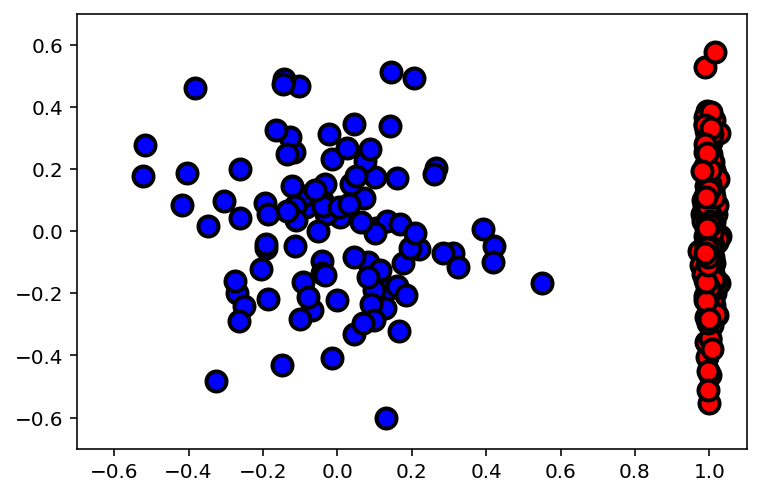

In [260]:
plotp(A.dot(z)+h[:,None], 'b')
plotp(y, 'r')
plt.xlim(-.7,1.1)
plt.ylim(-.7,.7);

Run Sinkhorn.

In [261]:
x = A.dot(z)+h[:,None]
f = np.zeros(n)
(P,Err) = Sinkhorn(distmat(x,y), epsilon,f,niter)

Compute gradient with respect to positions.

In [262]:
v = a.transpose() * x - y.dot(P.transpose())

gradient with respect to parameters

In [263]:
nabla_A = v.dot(z.transpose())
nabla_h = np.sum(v,1)

__Exercise 5__

Implement the gradient descent.

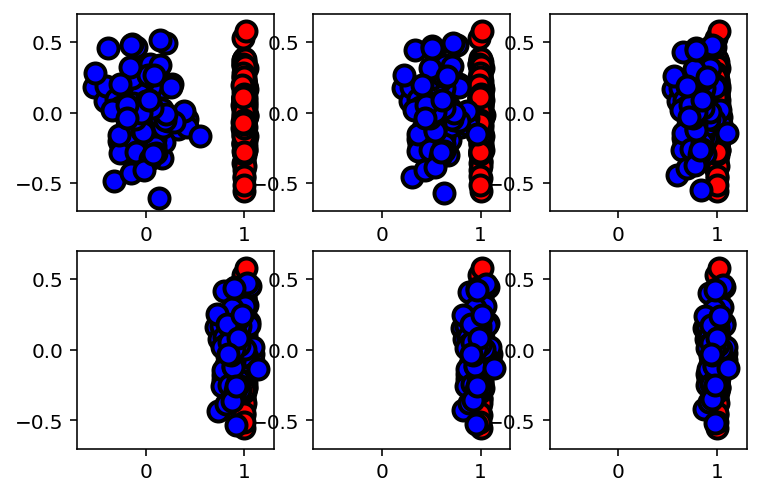

In [264]:
A = np.eye(2)
h = np.zeros(2)
# step size for the descent
tau_A = .8
tau_h = .1
# #iter for the gradient descent
giter = 40 
ndisp = np.round( np.linspace(0,giter-1,6) )
kdisp = 0
f = np.zeros(n)
for j in range(giter):
    x = A.dot(z)+h[:,None] 
    if ndisp[kdisp]==j:
        plt.subplot(2,3,kdisp+1)
        plotp(y, 'r')
        plotp(x, 'b')
        kdisp = kdisp+1
        plt.xlim(-.7,1.3)
        plt.ylim(-.7,.7)
    (P,Err) = Sinkhorn(distmat(x,y), epsilon,f,niter)
    v = a.transpose() * x - y.dot(P.transpose())
    nabla_A = v.dot(z.transpose())
    nabla_h = np.sum(v,1)
    A = A - tau_A * nabla_A
    h = h - tau_h * nabla_h   

__Exercise 5__

Test using a more complicated deformation (for instance a square being deformed by a random $A$.

Real params: (array([[-0.88704006, -0.2945528 ],
       [ 0.36191555,  1.09950015]]), array([0.6, 0. ]))


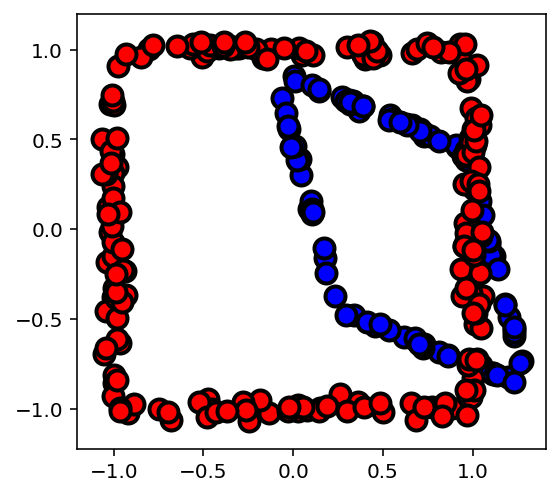

In [338]:
z = np.random.randn(2,n)
z /= np.linalg.norm(z, axis=0, ord=np.inf)
z = .6*z + .01* np.random.randn(2, n)
y = np.random.randn(2,m)*.2
y /= np.linalg.norm(y, axis=0, ord=np.inf)
y = y + .03 * np.random.randn(2,m)

# Initialize the parameters.

A_real = np.random.randn(2, 2)
h_real = np.array([0.6, 0.])

# Display the clouds.

plotp(A_real.dot(z)+h_real[:,None], 'b')
plotp(y, 'r')
plt.axis('scaled');
print('Real params:', (A_real, h_real))

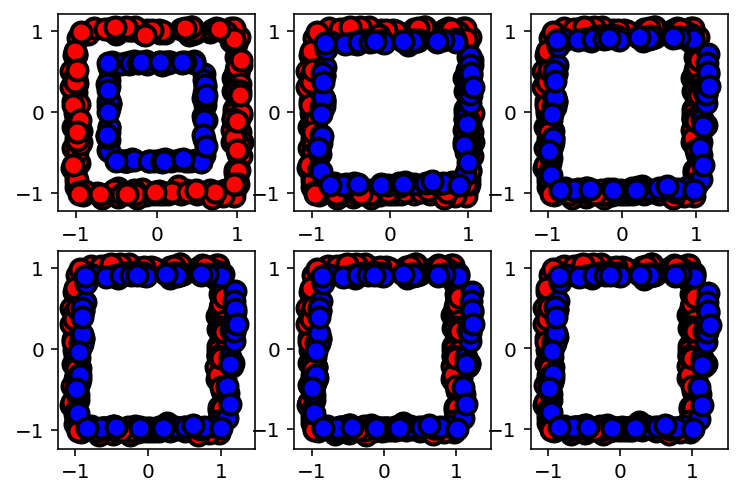

In [339]:
A = np.eye(2)
h = np.zeros(2)
# step size for the descent
tau_A = .8
tau_h = .1
# #iter for the gradient descent
giter = 40 
ndisp = np.round( np.linspace(0,giter-1,6) )
kdisp = 0
f = np.zeros(n)
for j in range(giter):
    x = A.dot(z)+h[:,None] 
    if ndisp[kdisp]==j:
        plt.subplot(2,3,kdisp+1)
        plotp(y, 'r')
        plotp(x, 'b')
        kdisp = kdisp+1
        
    (P,Err) = Sinkhorn(distmat(x,y), epsilon,f,niter, compute_errs=False)
    v = a.transpose() * x - y.dot(P.transpose())
    nabla_A = v.dot(z.transpose())
    nabla_h = np.sum(v,1)
    A = A - tau_A * nabla_A
    h = h - tau_h * nabla_h   

In [340]:
print('Est. params:', (A, h))

Est. params: (array([[ 1.75705673,  0.13428217],
       [-0.00787947,  1.5591054 ]]), array([ 0.12698854, -0.03554779]))
